# Data Preprocessing

The first step was understanding and visualizing the dataset. To do this we combined the data entries of the same timestamp for ozone and $PM_{2.5}$. The next step was to visualize the concentration and AQI for ozone as well as $PM_{2.5}$. Here we noticed missing values for certain timestamps as well as several outliers, especially for $PM_{2.5}$. The next step involves data pre-processing. Our first goal was outlier removal. For this, we calculated the inter-quartile range for each feature and all the values not lying in this range were set to zero. On these values and the ones that were already none, we use interpolation to have a rich dataset for model training.

We have experimented with several methods for interpolation namely: linear, polynomial and spline. For polynomial and spline we compare the performance of $3^{rd}$ and $5^{th}$ order functions as well. After visualizing the interpolated regions we found the best interpolated results for ozone and $PM_{2.5}$ with linear interpolation.



### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Read the data using AirNow API

In [ ]:
# Extracting the data from airnow API
url = "https://www.airnowapi.org/aq/data/?startDate=2023-01-05T19&endDate=2023-11-04T20&parameters=OZONE,PM25,PM10,CO,NO2,SO2&BBOX=-80.00824,40.410183,-79.87022,40.480205&dataType=B&format=text/csv&verbose=0&monitorType=0&includerawconcentrations=0&API_KEY=FB304044-F68A-4362-A58B-770F0192D163"
df = pd.read_csv(url)
df.to_csv("AirNowAPIData.csv",index= False)
print("Data Extracted")

Data Extracted


In [ ]:
# Add column heading
column_names = ["Latitude", "Longitude", "Timestamp", "Pollutant", "Concentration", "Unit", "AQI", "AQI Category"]
# Read the data from the CSV file
data = pd.read_csv("/content/AirNowAPIData.csv",names=column_names)
# Display the DataFrame
data

,Latitude,Longitude,Timestamp,Pollutant,Concentration,Unit,AQI,AQI Category
0,40.4656,-79.9611,2023-01-05T19:00,OZONE,32.0,PPB,30,1
1,40.4656,-79.9611,2023-01-05T19:00,PM2.5,5.4,UG/M3,23,1
2,40.4656,-79.9611,2023-01-05T20:00,OZONE,31.0,PPB,29,1
3,40.4656,-79.9611,2023-01-05T20:00,PM2.5,4.8,UG/M3,20,1
4,40.4656,-79.9611,2023-01-05T21:00,OZONE,35.0,PPB,32,1
...,...,...,...,...,...,...,...,...
14446,40.4656,-79.9611,2023-11-04T18:00,OZONE,37.0,PPB,34,1
14447,40.4656,-79.9611,2023-11-04T19:00,PM2.5,11.0,UG/M3,46,1
14448,40.4656,-79.9611,2023-11-04T19:00,OZONE,40.0,PPB,37,1
14449,40.4656,-79.9611,2023-11-04T20:00,PM2.5,10.6,UG/M3,44,1


In [ ]:
# Creating and storing filtered data by separating PM2.5 and OZONE values into different columns
# This filtering is useful for interpolating data used for data imputation
# ---------------------------------------------------------------------------------------------#

filtered_data = data[data['Pollutant'].isin(['PM2.5', 'OZONE'])]

# Separating PM2.5 and OZONE values into different columns
preprocessed_data = filtered_data.pivot(index=["Timestamp"], columns="Pollutant", values=["Concentration", "Unit", "AQI", "AQI Category"])
preprocessed_data.reset_index(inplace=True)

# Flattening the multi-level column names
preprocessed_data.columns = ['_'.join(col).strip() for col in preprocessed_data.columns.values]
preprocessed_data.rename(columns={"Timestamp_": "Timestamp", "Concentration_PM2.5": "PM2.5_Concentration", "Unit_PM2.5": "PM2.5_Unit ",
                         "AQI_PM2.5": "PM2.5_AQI", "AQI Category_PM2.5": "PM2.5_AQI_Category", "Concentration_OZONE": "Ozone_Concentration",
                         "Unit_OZONE": "Ozone_Unit", "AQI_OZONE": "Ozone_AQI", "AQI Category_OZONE": "Ozone_AQI_Category"}, inplace=True)

preprocessed_data.to_csv("/content/preprocessed_data.csv", index=False)
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7259 entries, 0 to 7258
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Timestamp            7259 non-null   object
 1   Ozone_Concentration  7240 non-null   object
 2   PM2.5_Concentration  7211 non-null   object
 3   Ozone_Unit           7240 non-null   object
 4   PM2.5_Unit           7211 non-null   object
 5   Ozone_AQI            7240 non-null   object
 6   PM2.5_AQI            7211 non-null   object
 7   Ozone_AQI_Category   7240 non-null   object
 8   PM2.5_AQI_Category   7211 non-null   object
dtypes: object(9)
memory usage: 510.5+ KB


In [ ]:
#Print information about the pre-processed data
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7259 entries, 0 to 7258
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Timestamp            7259 non-null   object
 1   Ozone_Concentration  7240 non-null   object
 2   PM2.5_Concentration  7211 non-null   object
 3   Ozone_Unit           7240 non-null   object
 4   PM2.5_Unit           7211 non-null   object
 5   Ozone_AQI            7240 non-null   object
 6   PM2.5_AQI            7211 non-null   object
 7   Ozone_AQI_Category   7240 non-null   object
 8   PM2.5_AQI_Category   7211 non-null   object
dtypes: object(9)
memory usage: 510.5+ KB


In [ ]:
#Change the data type of Timestamp to datetime
preprocessed_data['Timestamp']=pd.to_datetime(preprocessed_data['Timestamp'])
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7259 entries, 0 to 7258
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Timestamp            7259 non-null   datetime64[ns]
 1   Ozone_Concentration  7240 non-null   object        
 2   PM2.5_Concentration  7211 non-null   object        
 3   Ozone_Unit           7240 non-null   object        
 4   PM2.5_Unit           7211 non-null   object        
 5   Ozone_AQI            7240 non-null   object        
 6   PM2.5_AQI            7211 non-null   object        
 7   Ozone_AQI_Category   7240 non-null   object        
 8   PM2.5_AQI_Category   7211 non-null   object        
dtypes: datetime64[ns](1), object(8)
memory usage: 510.5+ KB


In [ ]:
#Generating descriptive statistics of the pre-processed data to perform statistical analysis
preprocessed_data.describe()

<ipython-input-9-c82941d6e8a7>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  preprocessed_data.describe()


,Timestamp,Ozone_Concentration,PM2.5_Concentration,Ozone_Unit,PM2.5_Unit,Ozone_AQI,PM2.5_AQI,Ozone_AQI_Category,PM2.5_AQI_Category
count,7259,7240.0,7211.0,7240,7211,7240.0,7211.0,7240.0,7211.0
unique,7259,72.0,453.0,1,1,68.0,173.0,4.0,6.0
top,2023-01-05 19:00:00,27.0,6.2,PPB,UG/M3,31.0,28.0,1.0,1.0
freq,1,232.0,80.0,7240,7211,416.0,200.0,7133.0,5166.0
first,2023-01-05 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-11-04 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Set Timestamp to be the index which is useful for creating plots
data_for_plots = preprocessed_data.set_index('Timestamp')

# Analyzing Ozone Concentration

Text(0, 0.5, 'Ozone Concentration (PPB)')

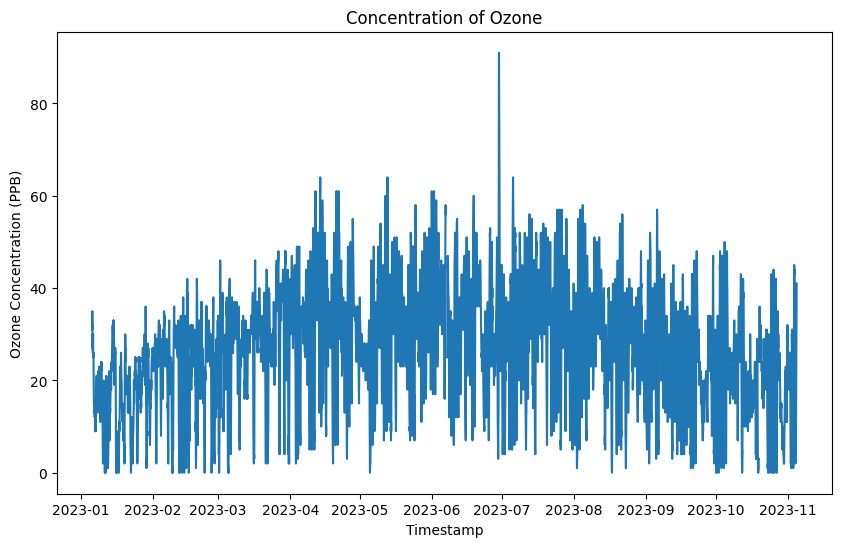

In [ ]:
# Plot the Ozone Concentration
plt.figure(figsize = (10,6))
plt.plot(data_for_plots['Ozone_Concentration'])
plt.title("Concentration of Ozone")
plt.xlabel("Timestamp")
plt.ylabel("Ozone Concentration (PPB)")

In [ ]:
#Finding indices with missing values for Ozone concentration
ozone_conc_missing = np.where(preprocessed_data.Ozone_Concentration.isnull())[0]
print(f'Indices with missing values of Ozone Concentration: {ozone_conc_missing}')

Indices with missing values of Ozone Concentration: [1869 3651 3652 3653 3654 3655 3656 3657 3658 3659 3660 3661 3662 3663
 3664 6869 6870 6871 6872]


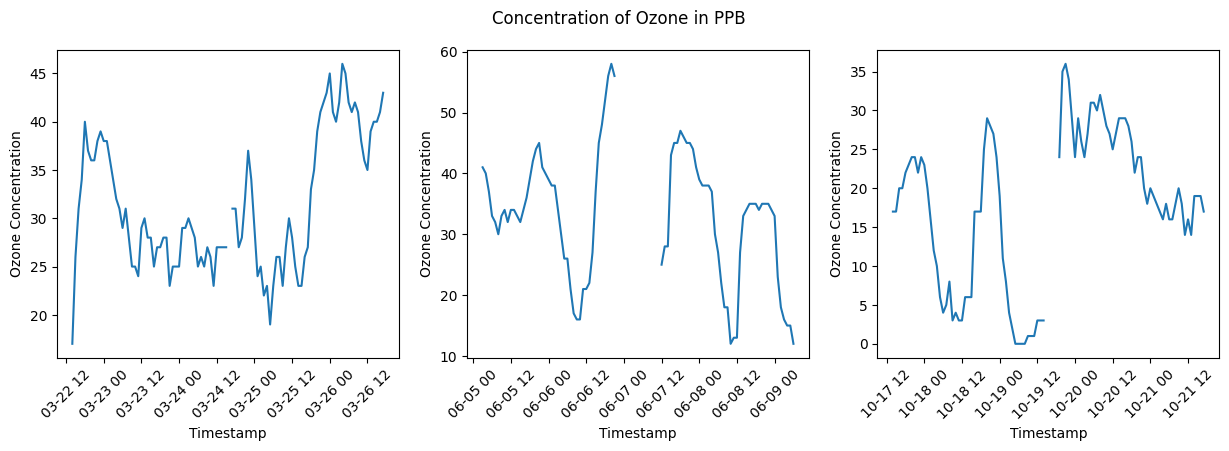

In [ ]:
# Picking the 1st index, followed by the 9th and 17th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 8, -3]
#Visualize the timeseries for Ozone Concentration with missing values
plt.figure(figsize = (15, 4))
for i in range(0, len(picked_idx)):
  plt.subplot(1, 3, i+1)
  plt.suptitle("Concentration of Ozone in PPB")
  plt.plot(data_for_plots['Ozone_Concentration'][ozone_conc_missing[picked_idx[i]] - 50 : ozone_conc_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('Ozone Concentration')

# Analyzing PM2.5 Concentration

Text(0, 0.5, 'PM 2.5 Concentration (UG/M3)')

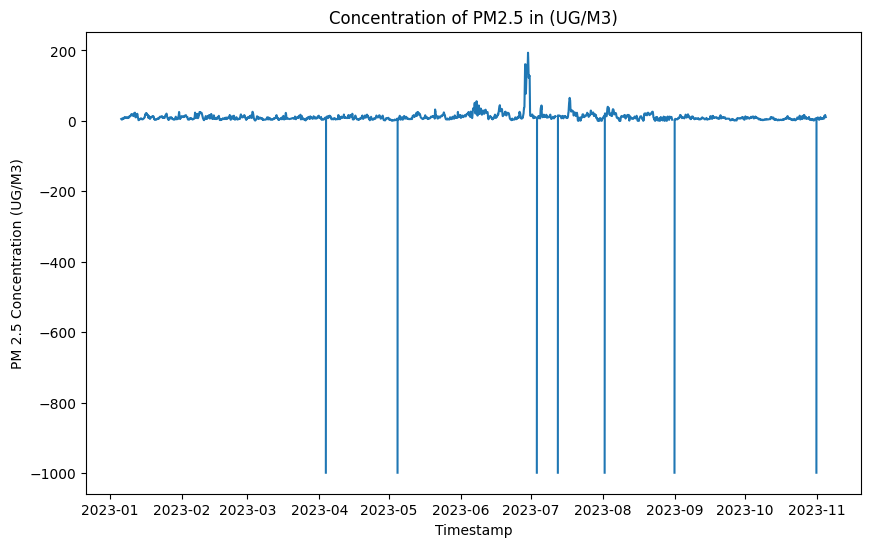

In [ ]:
# Plot the PM2.5 Concentration
plt.figure(figsize = (10,6))
plt.plot(data_for_plots['PM2.5_Concentration'])
plt.title("Concentration of PM2.5 in (UG/M3)")
plt.xlabel("Timestamp")
plt.ylabel("PM 2.5 Concentration (UG/M3)")

In [ ]:
# Setting negative PM2.5 Concentration values to null
preprocessed_data.loc[preprocessed_data['PM2.5_Concentration'] < 0, 'PM2.5_Concentration'] = np.NaN
data_for_plots.loc[data_for_plots['PM2.5_Concentration'] < 0, 'PM2.5_Concentration'] = np.NaN

In [ ]:
#Finding indices with missing values for PM2.5 concentration which is useful for plotting
pm25_conc_missing = np.where(preprocessed_data['PM2.5_Concentration'].isna())[0]
print(f'Indices with missing values of PM2.5 Concentration: {pm25_conc_missing}')

Indices with missing values of PM2.5 Concentration: [2111 2112 2851 2852 4279 4280 4473 4474 4475 4476 4477 4478 4479 4480
 4481 4482 4483 4484 4485 4486 4487 4488 4489 4490 4491 4492 4973 4974
 4975 5673 5674 5675 5676 5677 5678 5679 5680 5681 5682 5683 5684 5685
 5686 5687 5688 5689 5690 5691 5692 5693 5694 5695 5696 7160 7161]


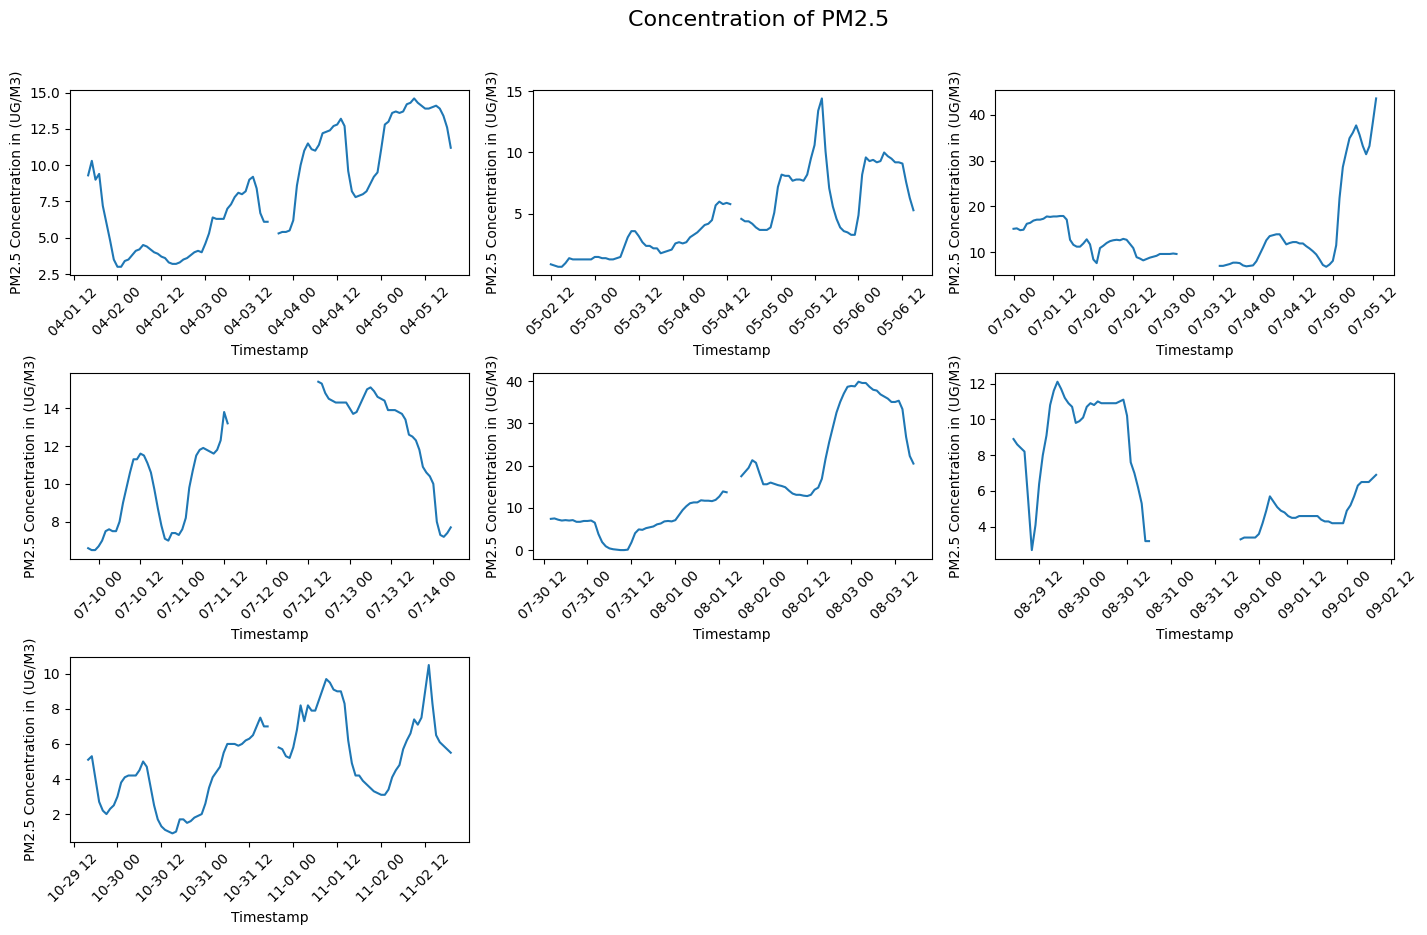

In [ ]:
# Picking the 1st index, followed by the 3rd, 5th, 16th, 28th, 41st and 54th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 2, 4, 15, 27, 41, -2]
#Visualize the timeseries for PM2.5 Concentration with missing values
plt.figure(figsize = (15, 10))
for i in range(0, len(picked_idx)):
  plt.subplot(3, 3, i+1)
  plt.plot(data_for_plots['PM2.5_Concentration'][pm25_conc_missing[picked_idx[i]] - 50 : pm25_conc_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('PM2.5 Concentration in (UG/M3)')

plt.suptitle("Concentration of PM2.5", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 0.95, 0.95])  # Adjust the padding between and around subplots
plt.show()

# Analyzing Air Quality Index (AQI) of Ozone

Text(0, 0.5, 'Ozone AQI')

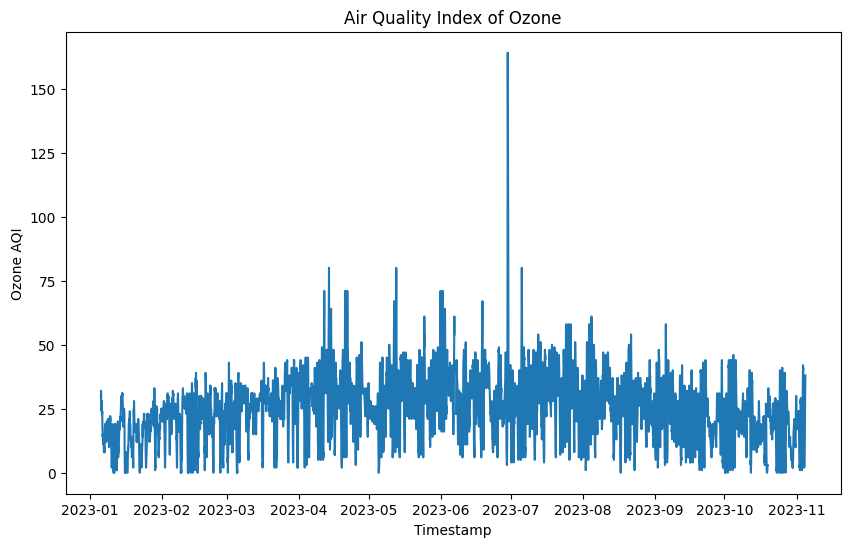

In [ ]:
# Plot the Ozone AQI
plt.figure(figsize = (10,6))
plt.plot(data_for_plots['Ozone_AQI'])
plt.title("Air Quality Index of Ozone")
plt.xlabel("Timestamp")
plt.ylabel("Ozone AQI")

In [ ]:
#Finding indices with missing values for Ozone AQI which is useful for plotting
ozone_aqi_missing = np.where(data_for_plots['Ozone_AQI'].isna())[0]
print(f'Indices with missing values of Ozone AQI: {ozone_aqi_missing}')

Indices with missing values of Ozone AQI: [1869 3651 3652 3653 3654 3655 3656 3657 3658 3659 3660 3661 3662 3663
 3664 6869 6870 6871 6872]


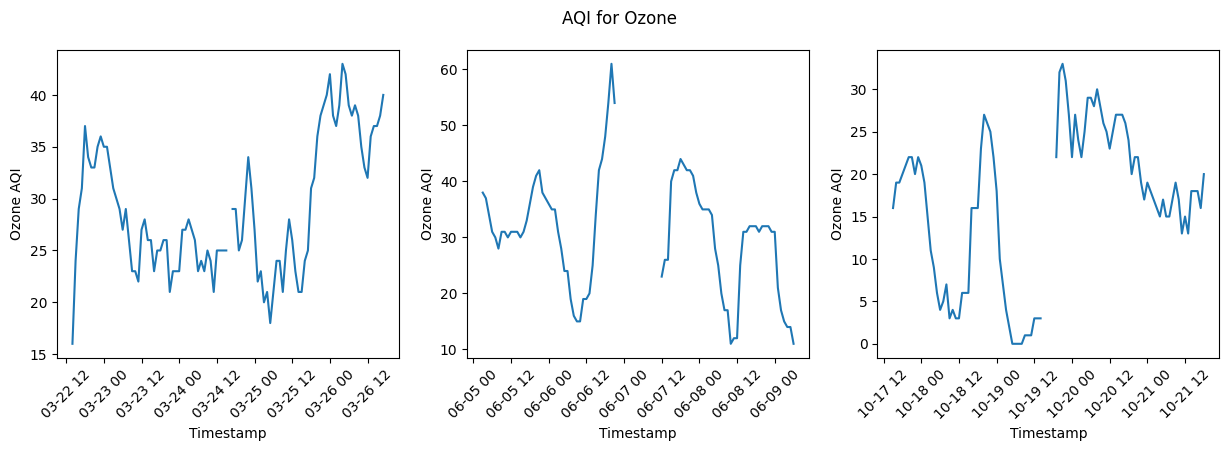

In [ ]:
# Picking the 1st index, followed by the 9th and 19th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 8, -2]
#Visualize the timeseries for Ozone AQI with missing values
plt.figure(figsize = (15, 4))
for i in range(0, len(picked_idx)):
  plt.subplot(1, 3, i+1)
  plt.suptitle("AQI for Ozone")
  plt.plot(data_for_plots['Ozone_AQI'][ozone_aqi_missing[picked_idx[i]] - 50 : ozone_aqi_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('Ozone AQI')

# Analyzing Air Quality Index (AQI) of PM2.5

Text(0, 0.5, 'PM 2.5 AQI')

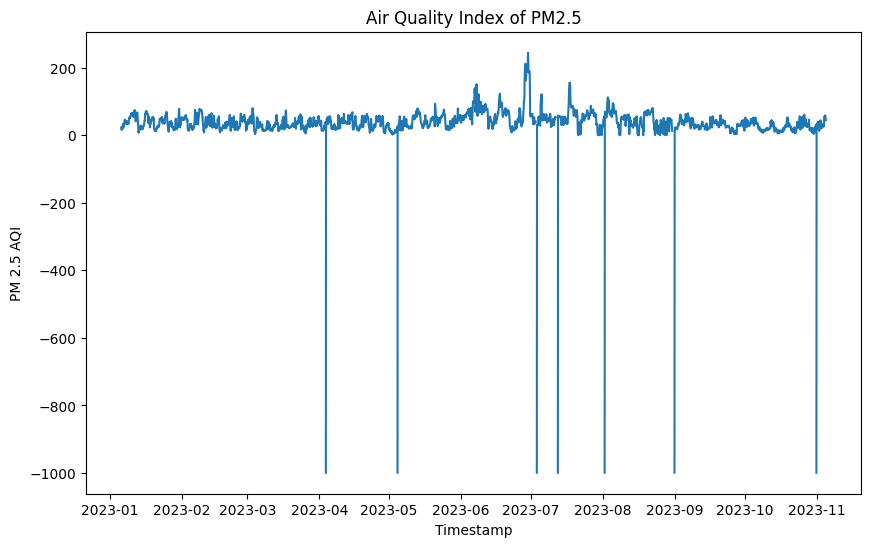

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(data_for_plots['PM2.5_AQI'])
plt.title("Air Quality Index of PM2.5")
plt.xlabel("Timestamp")
plt.ylabel("PM 2.5 AQI")

In [ ]:
# Setting negative PM2.5 AQI values to null
preprocessed_data.loc[preprocessed_data['PM2.5_AQI'] < 0, 'PM2.5_AQI'] = np.NaN
data_for_plots.loc[data_for_plots['PM2.5_AQI'] < 0, 'PM2.5_AQI'] = np.NaN

In [ ]:
#Finding indices with missing values for PM2.5 AQI which is useful for plotting
pm25_aqi_missing = np.where(preprocessed_data['PM2.5_AQI'].isna())[0]
print(f'Indices with missing values of PM2.5 AQI: {pm25_aqi_missing}')

Indices with missing values of PM2.5 AQI: [2111 2112 2851 2852 4279 4280 4473 4474 4475 4476 4477 4478 4479 4480
 4481 4482 4483 4484 4485 4486 4487 4488 4489 4490 4491 4492 4973 4974
 4975 5673 5674 5675 5676 5677 5678 5679 5680 5681 5682 5683 5684 5685
 5686 5687 5688 5689 5690 5691 5692 5693 5694 5695 5696 7160 7161]


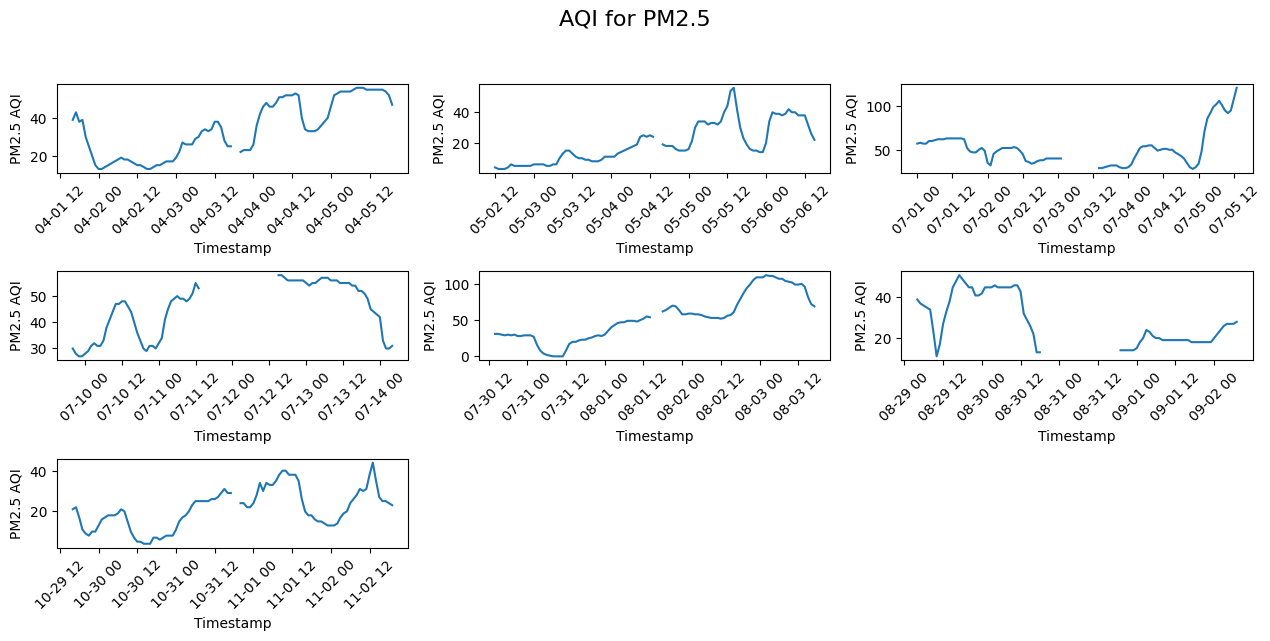

In [ ]:
# Picking the 1st index, followed by the 3rd, 5th, 15th, 28th, 41st and 54th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 2, 4, 14, 27, 40, -2]
#Visualize the timeseries for PM2.5 AQI with missing values
plt.figure(figsize = (16, 6.5))
for i in range(0, len(picked_idx)):
  plt.subplot(3, 3, i+1)
  plt.plot(data_for_plots['PM2.5_AQI'][pm25_aqi_missing[picked_idx[i]] - 50 : pm25_aqi_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('PM2.5 AQI')

plt.suptitle("AQI for PM2.5", fontsize=16, x =0.4)
plt.tight_layout(rect=[0, 0.001, 0.8, 0.95])
plt.show()

# Experiments for Interpolation used for Data Imputation

## Experiments for Interpolation with Ozone Concentration

### Linear Interpolation

In [ ]:
# Read the data from the CSV file
preprocessed_data = pd.read_csv("/content/preprocessed_data.csv")
#Perform Linear Interpolation
preprocessed_data.interpolate(method='linear', limit_direction='forward', axis=0,inplace=True)

In [ ]:
#Create data_for_plots useful for plotting timeseries
data_for_plots = preprocessed_data.copy()
data_for_plots['Timestamp']=pd.to_datetime(data_for_plots['Timestamp'])
data_for_plots = data_for_plots.set_index('Timestamp')

In [ ]:
print(f'Indices with missing values of Ozone Concentration: {ozone_conc_missing}')

Indices with missing values of Ozone Concentration: [1869 3651 3652 3653 3654 3655 3656 3657 3658 3659 3660 3661 3662 3663
 3664 6869 6870 6871 6872]


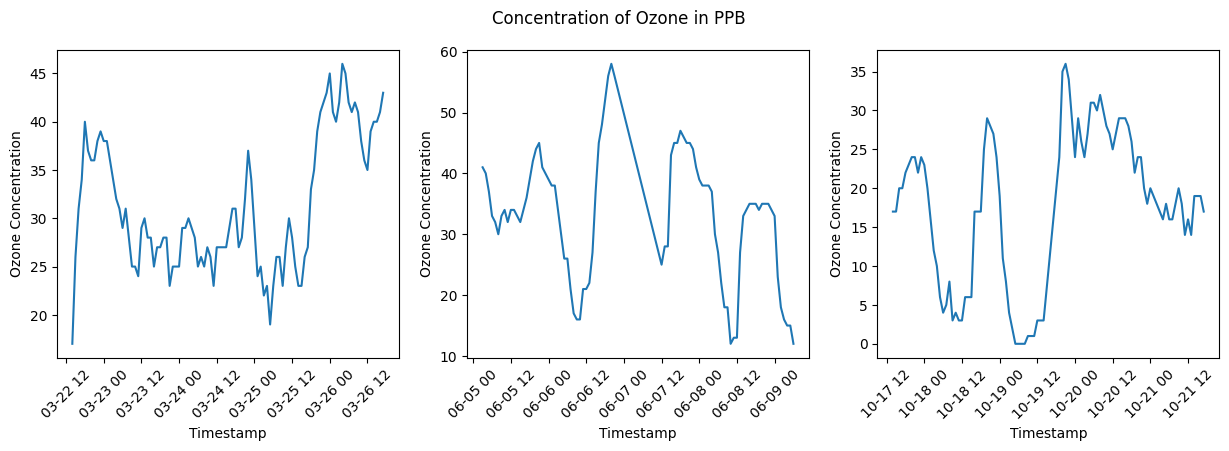

In [ ]:
# Picking the 1st index, followed by the 9th and 17th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 8, -3]
#Visualize the timeseries for Ozone Concentration with interpolated values
plt.figure(figsize = (15, 4))
for i in range(0, len(picked_idx)):
  plt.subplot(1, 3, i+1)
  plt.suptitle("Concentration of Ozone in PPB")
  plt.plot(data_for_plots['Ozone_Concentration'][ozone_conc_missing[picked_idx[i]] - 50 : ozone_conc_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('Ozone Concentration')

### Sline Interpolation

In [ ]:
# Read the data from the CSV file
preprocessed_data = pd.read_csv("/content/preprocessed_data.csv")
#Perform Sline Interpolation
preprocessed_data.interpolate(method='slinear', limit_direction='forward', axis=0,inplace=True)

In [ ]:
#Create data_for_plots useful for plotting timeseries
data_for_plots = preprocessed_data.copy()
data_for_plots['Timestamp']=pd.to_datetime(data_for_plots['Timestamp'])
data_for_plots = data_for_plots.set_index('Timestamp')

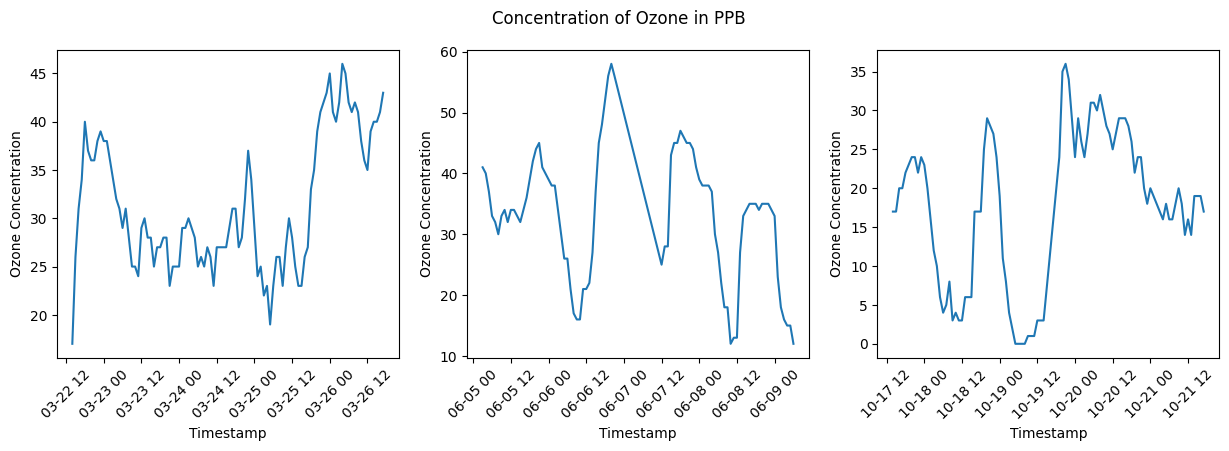

In [ ]:
# Picking the 1st index, followed by the 9th and 17th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 8, -3]
#Visualize the timeseries for Ozone Concentration with interpolated values
plt.figure(figsize = (15, 4))
for i in range(0, len(picked_idx)):
  plt.subplot(1, 3, i+1)
  plt.suptitle("Concentration of Ozone in PPB")
  plt.plot(data_for_plots['Ozone_Concentration'][ozone_conc_missing[picked_idx[i]] - 50 : ozone_conc_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('Ozone Concentration')

### Spline 3 Interpolation

In [ ]:
# Read the data from the CSV file
preprocessed_data = pd.read_csv("/content/preprocessed_data.csv")
#Perform Spline 3 Interpolation
preprocessed_data.interpolate(method='spline', order=3,limit_direction='forward', axis=0,inplace=True)

In [ ]:
#Create data_for_plots useful for plotting timeseries
data_for_plots = preprocessed_data.copy()
data_for_plots['Timestamp']=pd.to_datetime(data_for_plots['Timestamp'])
data_for_plots = data_for_plots.set_index('Timestamp')

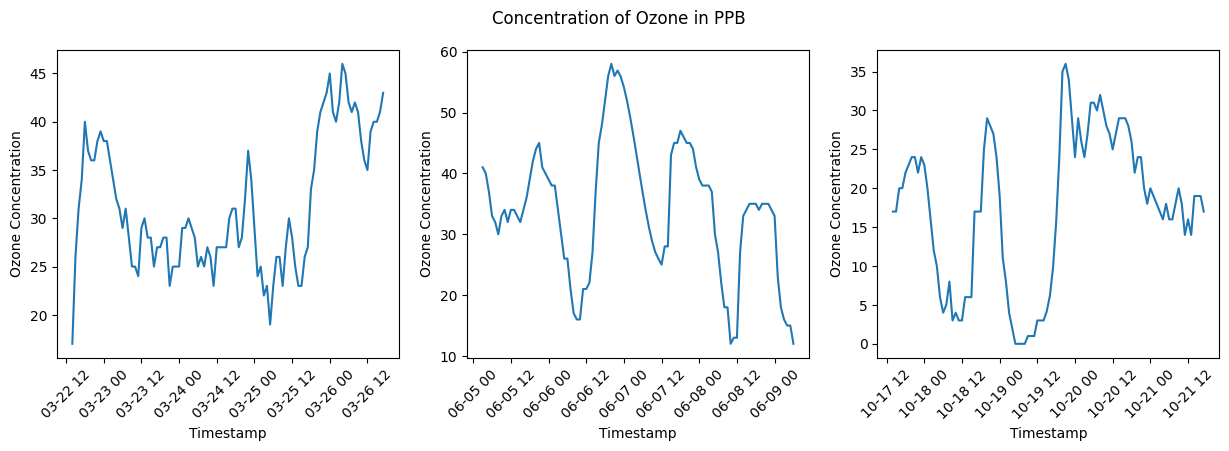

In [ ]:
# Picking the 1st index, followed by the 9th and 17th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 8, -3]
#Visualize the timeseries for Ozone Concentration with interpolated values
plt.figure(figsize = (15, 4))
for i in range(0, len(picked_idx)):
  plt.subplot(1, 3, i+1)
  plt.suptitle("Concentration of Ozone in PPB")
  plt.plot(data_for_plots['Ozone_Concentration'][ozone_conc_missing[picked_idx[i]] - 50 : ozone_conc_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('Ozone Concentration')

### Spline 5 Interpolation

In [ ]:
# Read the data from the CSV file
preprocessed_data = pd.read_csv("/content/preprocessed_data.csv")
#Perform Spline 5 Interpolation
preprocessed_data.interpolate(method='spline', order=5, limit_direction='forward', axis=0,inplace=True)

In [ ]:
#Create data_for_plots useful for plotting timeseries
data_for_plots = preprocessed_data.copy()
data_for_plots['Timestamp']=pd.to_datetime(data_for_plots['Timestamp'])
data_for_plots = data_for_plots.set_index('Timestamp')

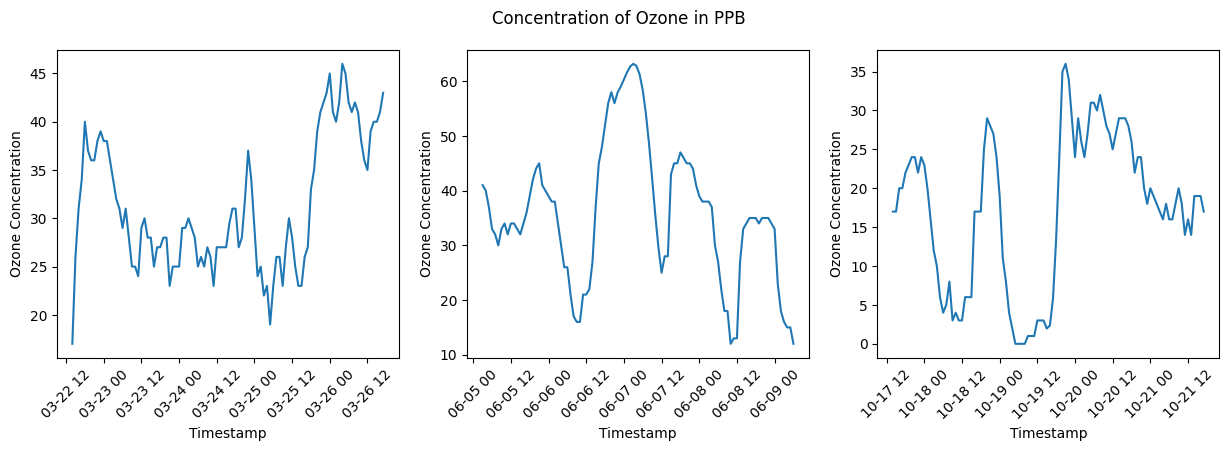

In [ ]:
# Picking the 1st index, followed by the 9th and 17th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 8, -3]
#Visualize the timeseries for Ozone Concentration with interpolated values
plt.figure(figsize = (15, 4))
for i in range(0, len(picked_idx)):
  plt.subplot(1, 3, i+1)
  plt.suptitle("Concentration of Ozone in PPB")
  plt.plot(data_for_plots['Ozone_Concentration'][ozone_conc_missing[picked_idx[i]] - 50 : ozone_conc_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('Ozone Concentration')

### Polynomial 3 Interpolation

In [ ]:
# Read the data from the CSV file
preprocessed_data = pd.read_csv("/content/preprocessed_data.csv")
#Perform Spline 5 Interpolation
preprocessed_data.interpolate(method='polynomial', order=3, limit_direction='forward', axis=0,inplace=True)

In [ ]:
#Create data_for_plots useful for plotting timeseries
data_for_plots = preprocessed_data.copy()
data_for_plots['Timestamp']=pd.to_datetime(data_for_plots['Timestamp'])
data_for_plots = data_for_plots.set_index('Timestamp')

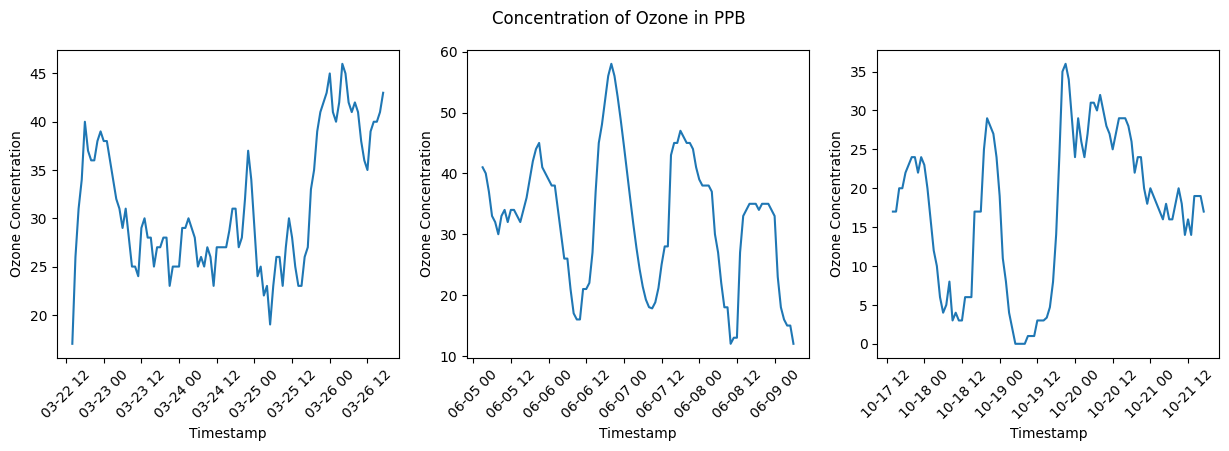

In [ ]:
# Picking the 1st index, followed by the 9th and 17th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 8, -3]
#Visualize the timeseries for Ozone Concentration with interpolated values
plt.figure(figsize = (15, 4))
for i in range(0, len(picked_idx)):
  plt.subplot(1, 3, i+1)
  plt.suptitle("Concentration of Ozone in PPB")
  plt.plot(data_for_plots['Ozone_Concentration'][ozone_conc_missing[picked_idx[i]] - 50 : ozone_conc_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('Ozone Concentration')

### Polynomial 5 Interpolation

In [ ]:
# Read the data from the CSV file
preprocessed_data = pd.read_csv("/content/preprocessed_data.csv")
#Perform Spline 5 Interpolation
preprocessed_data.interpolate(method='polynomial', order=5, limit_direction='forward', axis=0,inplace=True)

In [ ]:
#Create data_for_plots useful for plotting timeseries
data_for_plots = preprocessed_data.copy()
data_for_plots['Timestamp']=pd.to_datetime(data_for_plots['Timestamp'])
data_for_plots = data_for_plots.set_index('Timestamp')

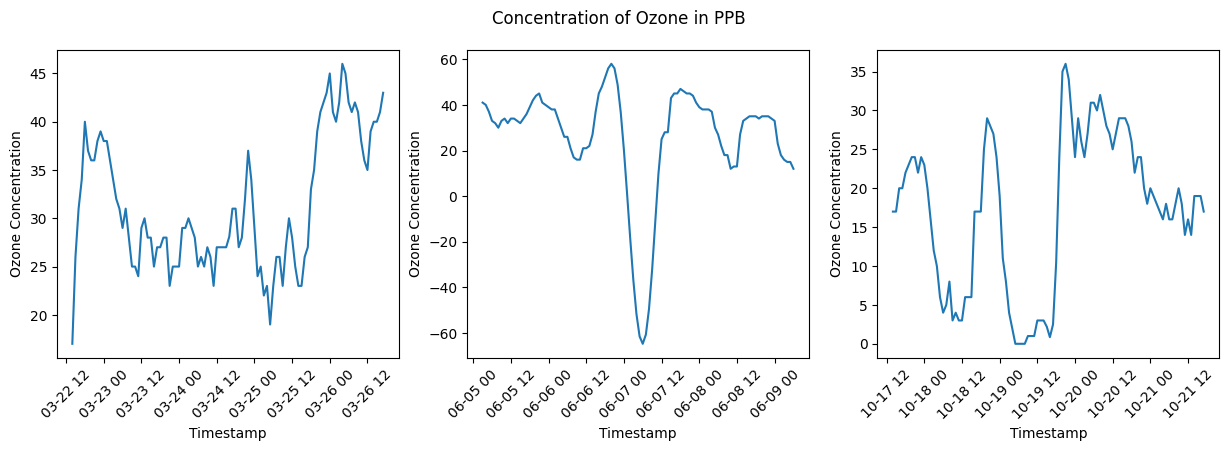

In [ ]:
# Picking the 1st index, followed by the 9th and 17th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 8, -3]
#Visualize the timeseries for Ozone Concentration with interpolated values
plt.figure(figsize = (15, 4))
for i in range(0, len(picked_idx)):
  plt.subplot(1, 3, i+1)
  plt.suptitle("Concentration of Ozone in PPB")
  plt.plot(data_for_plots['Ozone_Concentration'][ozone_conc_missing[picked_idx[i]] - 50 : ozone_conc_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('Ozone Concentration')

##Experiments for Interpolation with PM 2.5 Concentration




### Spline 3 Interpolation

In [ ]:
# Read the data from the CSV file
preprocessed_data = pd.read_csv("/content/preprocessed_data.csv")

# Setting negative PM2.5 AQI values to null
preprocessed_data.loc[preprocessed_data['PM2.5_AQI'] < 0, 'PM2.5_AQI'] = np.NaN
# Setting negative PM2.5 Concentration values to null
preprocessed_data.loc[preprocessed_data['PM2.5_Concentration'] < 0, 'PM2.5_Concentration'] = np.NaN
#Perform Linear Interpolation
preprocessed_data.interpolate(method='spline',order=3, limit_direction='forward', axis=0,inplace=True)

In [ ]:
#Create data_for_plots useful for plotting timeseries
data_for_plots = preprocessed_data.copy()
data_for_plots['Timestamp']=pd.to_datetime(data_for_plots['Timestamp'])
data_for_plots = data_for_plots.set_index('Timestamp')

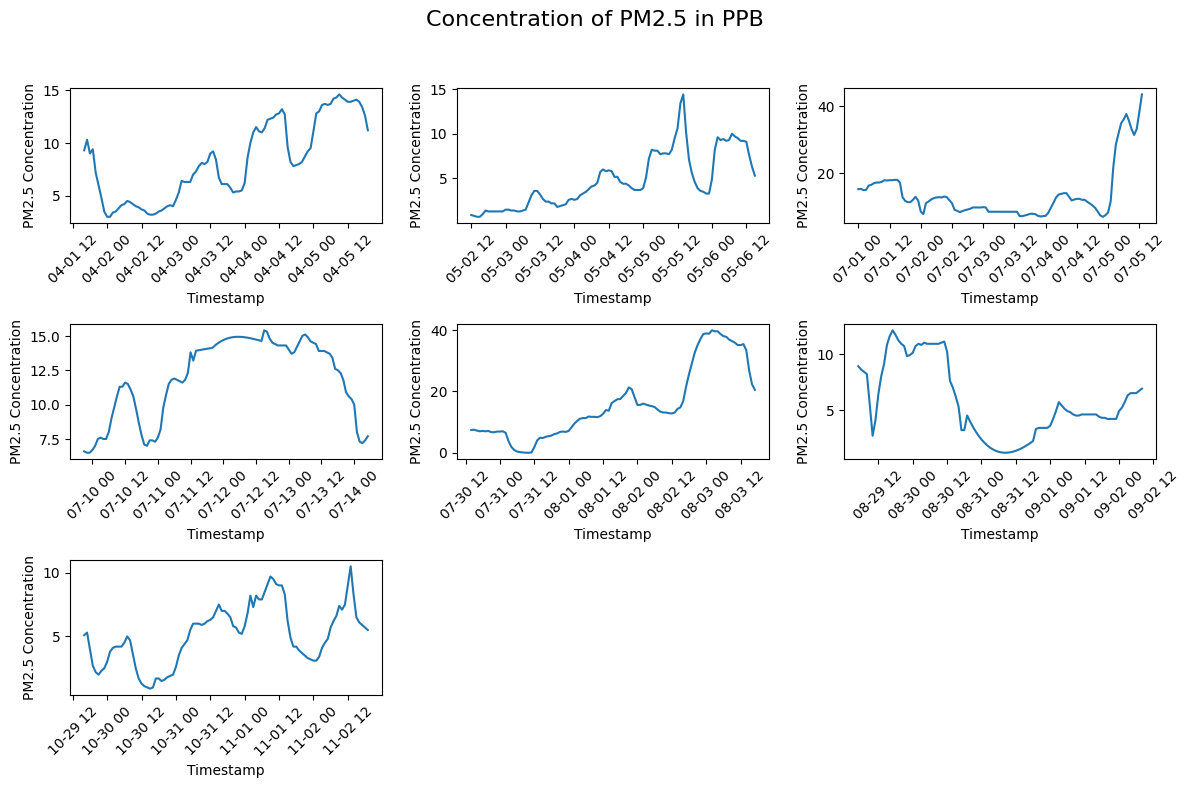

In [ ]:
# Picking the 1st index, followed by the 3rd, 5th, 16th, 28th, 41st and 54th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 2, 4, 15, 27, 41, -2]
#Visualize the timeseries for PM2.5 Concentration with interpolated values
plt.figure(figsize = (15, 8))
for i in range(0, len(picked_idx)):
  plt.subplot(3, 3, i+1)
  plt.plot(data_for_plots['PM2.5_Concentration'][pm25_conc_missing[picked_idx[i]] - 50 : pm25_conc_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('PM2.5 Concentration')

plt.suptitle("Concentration of PM2.5 in PPB", fontsize=16, x =0.4)
plt.tight_layout(rect=[0, 0.001, 0.8, 0.95])
plt.show()

### Linear Interpolation

In [ ]:
# Read the data from the CSV file
preprocessed_data = pd.read_csv("/content/preprocessed_data.csv")

# Setting negative PM2.5 AQI values to null
preprocessed_data.loc[preprocessed_data['PM2.5_AQI'] < 0, 'PM2.5_AQI'] = np.NaN
# Setting negative PM2.5 Concentration values to null
preprocessed_data.loc[preprocessed_data['PM2.5_Concentration'] < 0, 'PM2.5_Concentration'] = np.NaN
#Perform Linear Interpolation
preprocessed_data.interpolate(method='linear',limit_direction='forward', axis=0,inplace=True)

In [ ]:
#Create data_for_plots useful for plotting timeseries
data_for_plots = preprocessed_data.copy()
data_for_plots['Timestamp']=pd.to_datetime(data_for_plots['Timestamp'])
data_for_plots = data_for_plots.set_index('Timestamp')

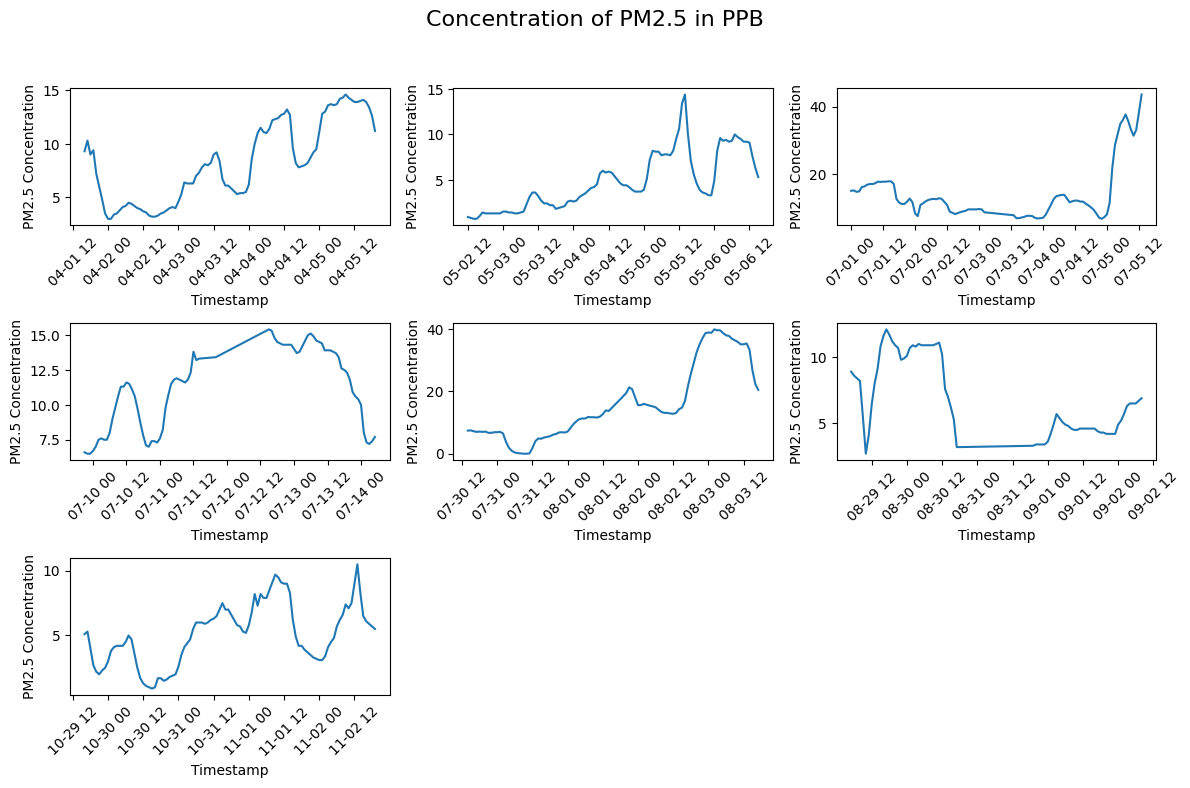

In [ ]:
# Picking the 1st index, followed by the 3rd, 5th, 16th, 28th, 41st and 54th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 2, 4, 15, 27, 41, -2]
#Visualize the timeseries for PM2.5 Concentration with interpolated values
plt.figure(figsize = (15, 8))
for i in range(0, len(picked_idx)):
  plt.subplot(3, 3, i+1)
  plt.plot(data_for_plots['PM2.5_Concentration'][pm25_conc_missing[picked_idx[i]] - 50 : pm25_conc_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('PM2.5 Concentration')

plt.suptitle("Concentration of PM2.5 in PPB", fontsize=16, x =0.4)
plt.tight_layout(rect=[0, 0.001, 0.8, 0.95])
plt.show()

# Removing outliers and then interpolating

### Using Interquartile Range (IQR) for finding outliers

In [ ]:
# Calculating the interquartile range for the specific column name and setting all values not in this range as zero
def quartiles(df,col_name):
  Q1 = df[col_name].quantile(0.25)
  Q3 =df[col_name].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  print(f'Column name: {name}, Lower Bound: {lower_bound}, Upper Bound: {upper_bound}')

  # Setting values less than lower bound of inter-quartile range to 0
  df.loc[df[col_name] < lower_bound, col_name] = np.NaN
  # Setting values larger than upper bound of inter-quartile range to 0
  df.loc[df[col_name] > upper_bound, col_name] = np.NaN

  return df

In [ ]:
# Read the data from the CSV file and pass each column through quartiles function
preprocessed_data = pd.read_csv("/content/preprocessed_data.csv")

# Setting negative PM2.5 AQI values to null
preprocessed_data.loc[preprocessed_data['PM2.5_AQI'] < 0, 'PM2.5_AQI'] = np.NaN
# Setting negative PM2.5 Concentration values to null
preprocessed_data.loc[preprocessed_data['PM2.5_Concentration'] < 0, 'PM2.5_Concentration'] = np.NaN

names = ['PM2.5_Concentration', 'PM2.5_AQI', 'Ozone_Concentration', 'Ozone_AQI']

for name in names:
    preprocessed_data = quartiles(preprocessed_data,name)

Column name: PM2.5_Concentration, Lower Bound: -5.1000000000000005, Upper Bound: 23.700000000000003
Column name: PM2.5_AQI, Lower Bound: -19.5, Upper Bound: 96.5
Column name: Ozone_Concentration, Lower Bound: -10.0, Upper Bound: 62.0
Column name: Ozone_AQI, Lower Bound: -8.0, Upper Bound: 56.0


In [ ]:
#Using linear interpolation for data imputation
df_linear = preprocessed_data.interpolate(method='linear',limit_direction='forward', axis=0)
df_final = df_linear.copy()

### Final Data Visualization

Text(0, 0.5, 'Ozone Concentration (PPB)')

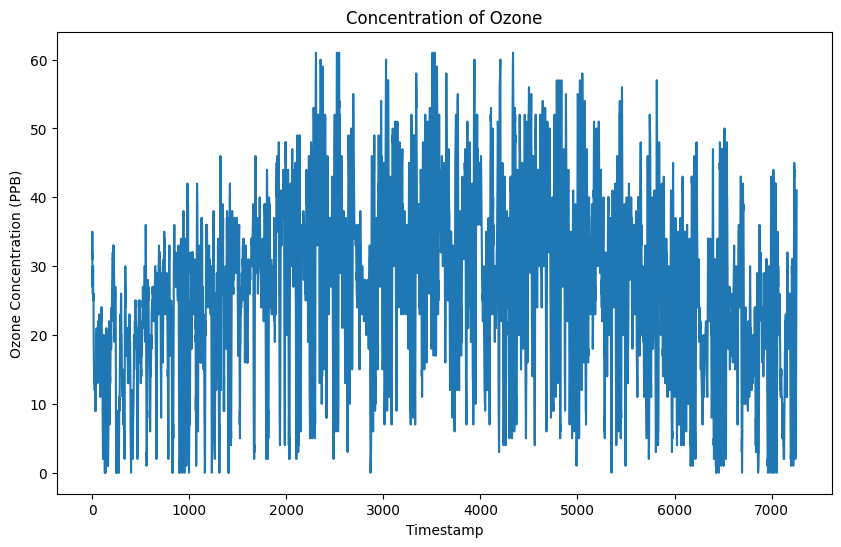

In [ ]:
# Plot the Ozone Concentration
plt.figure(figsize = (10,6))
plt.plot(df_final['Ozone_Concentration'])
plt.title("Concentration of Ozone")
plt.xlabel("Timestamp")
plt.ylabel("Ozone Concentration (PPB)")

Text(0, 0.5, 'AQI of Ozone')

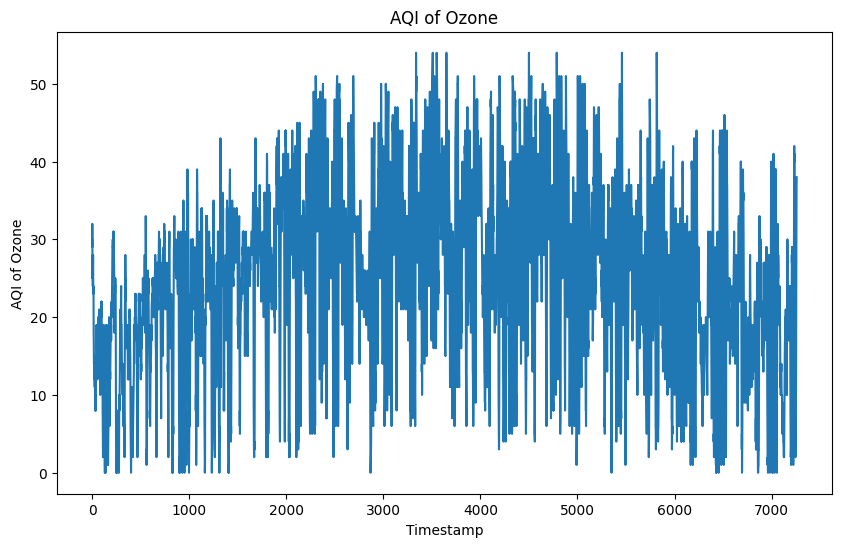

In [ ]:
# Plot the AQI of Ozone
plt.figure(figsize = (10,6))
plt.plot(df_final['Ozone_AQI'])
plt.title("AQI of Ozone")
plt.xlabel("Timestamp")
plt.ylabel("AQI of Ozone")

Text(0, 0.5, 'PM 2.5 Concentration (UG/M3)')

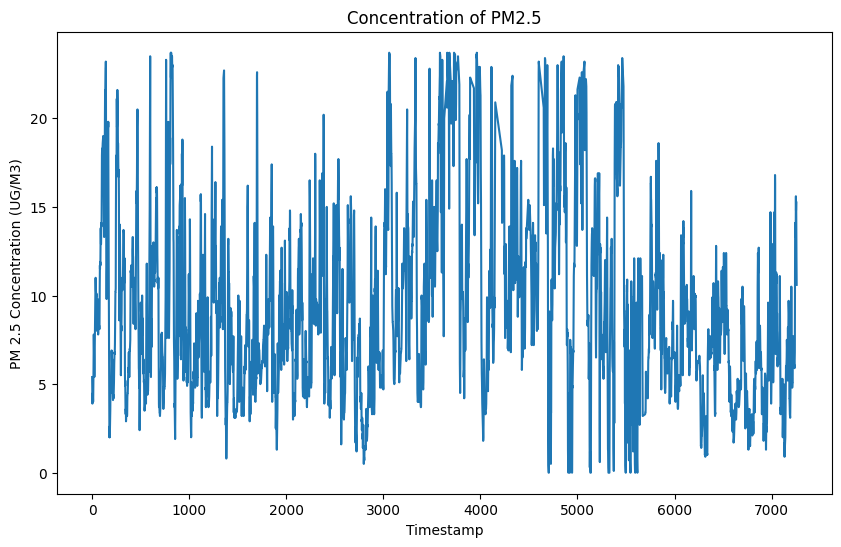

In [ ]:
# Plot the PM2.5 Concentration
plt.figure(figsize = (10,6))
plt.plot(df_final['PM2.5_Concentration'])
plt.title("Concentration of PM2.5")
plt.xlabel("Timestamp")
plt.ylabel("PM 2.5 Concentration (UG/M3)")

Text(0, 0.5, 'AQI of PM 2.5')

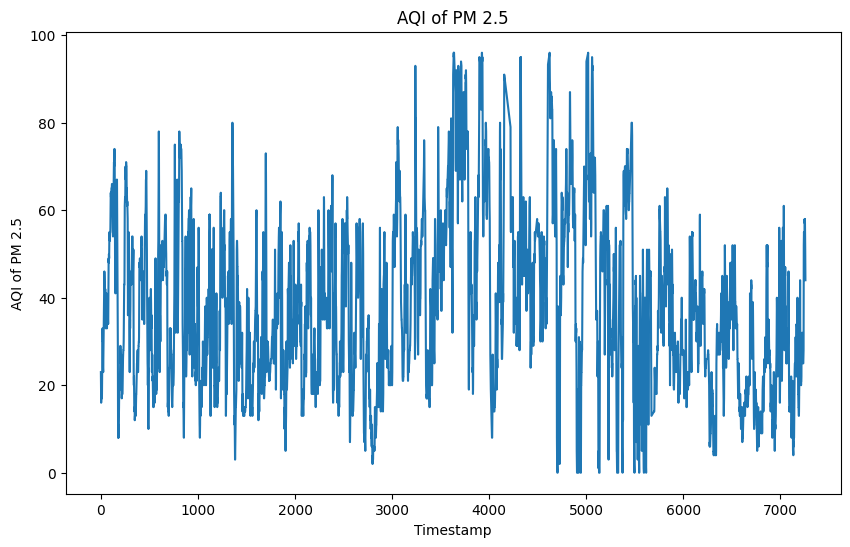

In [ ]:
# Plot the PM 2.5 AQI
plt.figure(figsize = (10,6))
plt.plot(df_final['PM2.5_AQI'])
plt.title("AQI of PM 2.5")
plt.xlabel("Timestamp")
plt.ylabel("AQI of PM 2.5")

In [ ]:
#Save the data after outlier removal and interpolation
df_final.to_csv("all_outlier_removed.csv",index=False)